# Machine Learning Coursework 

For the coursework, please make sure to implement your own code and not use libraries (except where explicitly asked). You will need to present your own code that performs nested cross-validation and the k-nearest neighbour algorithm, build confusion matrices, and estimate distances between data samples.

The purpose of this coursework is to help you:
- Get familiar with **common python modules / functions** used for ML in python
- Get practical experience **implementing** ML methods in python  
- Get practical experience regarding **parameter selection** for ML methods
- Get practical experience on **evaluating** ML methods and applying cross-validation

Notes:
- don't use libraries that implement kNN or cross-validation.  We want to see your code!
- Remember to comment all of your code (see here for tips: https://stackabuse.com/commenting-python-code/). You can also make use of Jupyter Markdown, where appropriate, to improve the layout of your code and documentation.
- Please add docstrings to all of your functions (so that users can get information on inputs/outputs and what each function does by typing SHIFT+TAB over the function name. For more detail on python docstrings, see here: [doc-strings docs](https://numpydoc.readthedocs.io/en/latest/format.html))
- When a question allows a free-form answer (e.g. what do you observe?), create a new markdown cell below and answer the question in the notebook. 
- Always save your notebook when you are done (this is not automatic)!
- Upload your completed notebook using the VLE

Plagiarism: please make sure that the material you submit has been created by you. Any sources you use for code should be properly referenced. Your code will be checked for plagiarism using appropriate software.

### Marking 

The grades in this coursework are allocated approximately as follows:

|                                                    | mark  |  
|----------------------------------------------------|-------|
| Data exploration (+ 2 questions)                   | 9     |  
| Code, docu. & comments (KNN + Evaluation + NCV)    | 12    |  
| Results (KNN folds + Summary + Confusion matrices) | 9     |  
| Final questions:                                   | 9     |  
| Overall quality & use of Markdown                  | 6     |  
| Total available                                    |**45** |  


## 1. Exploratory Data Analysis [9 pts]

In this coursework we are going to be working with the **Wine** dataset. This is a 178 sample dataset that categorises 3 different types of Italian wine using 13 different features. The code below loads the Wine dataset and selects a subset of features for you to work with. 

In [25]:
# set matplotlib backend to inline
%matplotlib inline 

# import modules
from sklearn import datasets 
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd

# load data
wine=datasets.load_wine()
#print(wine.DESCR)

# this dataset has 13 features, we will only choose a subset of these
df_wine = pd.DataFrame(wine.data, columns = wine.feature_names )
selected_features = ['alcohol','flavanoids','color_intensity','ash']

# extract the data as numpy arrays of features, X, and target, y
X = df_wine[selected_features].values
y = wine.target


df = pd.DataFrame(X)
df.columns = selected_features
df['target'] = y
df.describe()

,alcohol,flavanoids,color_intensity,ash,target
count,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.029270,5.058090,2.366517,0.938202
std,0.811827,0.998859,2.318286,0.274344,0.775035
min,11.030000,0.340000,1.280000,1.360000,0.000000
25%,12.362500,1.205000,3.220000,2.210000,0.000000
50%,13.050000,2.135000,4.690000,2.360000,1.000000
75%,13.677500,2.875000,6.200000,2.557500,2.000000
max,14.830000,5.080000,13.000000,3.230000,2.000000


### 1.1. Visualising the data

The first part of tackling any ML problem is visualising the data in order to understand some of the properties of the problem at hand.  When there are only a small number of classes and features, it is possible to use scatter plots to visualise interactions between different pairings of features. 

Your first task is to recreate a similar grid for the **Wine** dataset, with each off-diagonal subplot showing the interaction between two features, and each of the classes represented as a different colour. The on-diagonal subplots (representing a single feature) should show a distribution (or histogram) for that feature.     

You should create a function that, given data X and labels y, plots this grid.  The function should be invoked something like this:
        
    myplotGrid(X,y,...)
    
where X is your training data and y are the labels (you may also supply additional optional arguments). You can use an appropriate library to help you create the visualisation. You might want to code it yourself using matplotlib functions scatter and hist - however, this is not strictly necessary here, so try not spend too much time on this. 

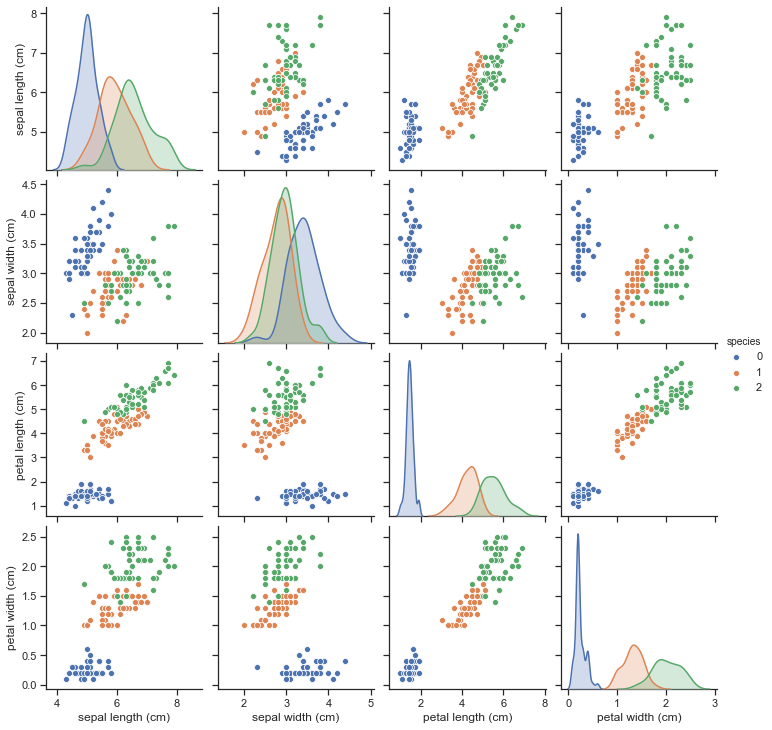

In [26]:
import seaborn as sns

def myplotGrid(df, target):
   return sns.pairplot(data=df, hue=target, palette='crest')

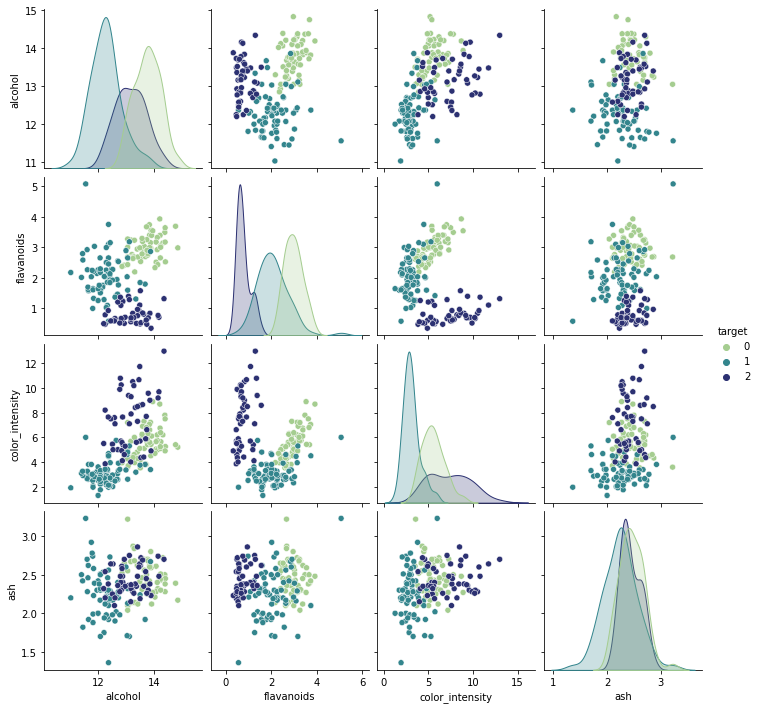

In [27]:
# run the plotting function
myplotGrid(df, 'target')

### 1.2. Exploratory Data Analysis under noise

When data are collected under real-world settings they usually contain some amount of noise that makes classification more challenging. In the cell below, invoke your exploratory data analysis function above on a noisy version of your data X.

Try to perturb your data with some Gaussian noise,

    # initialize random seed to replicate results over different runs
    mySeed = 12345 
    np.random.seed(mySeed) 
    XN=X+np.random.normal(0,0.5,X.shape)
    
and then invoke

    myplotGrid(XN,y)

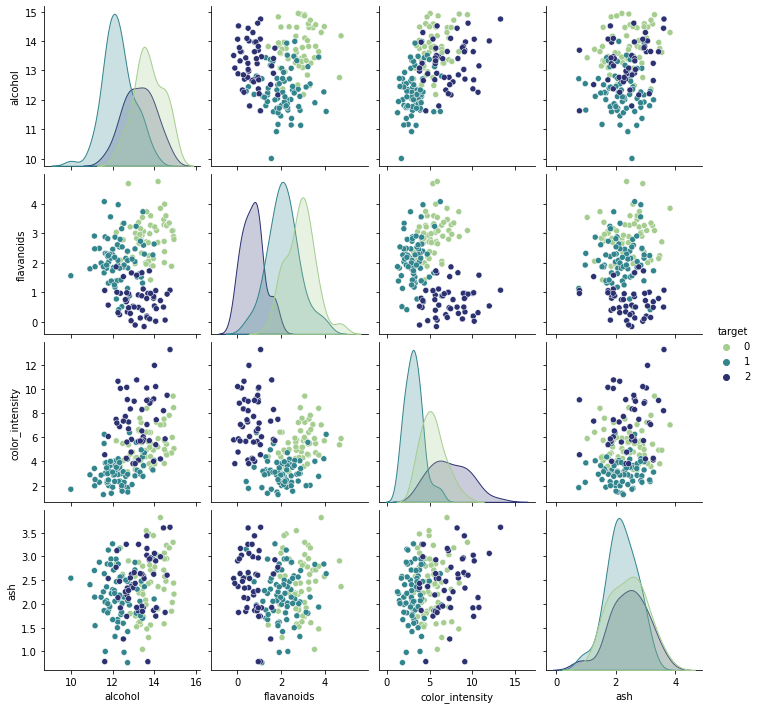

In [28]:
# noise code 
np.random.seed(12)
noise = np.random.normal(0,0.5, X.shape)

XN = X + noise
ndf = pd.DataFrame(XN)
ndf.columns = selected_features
ndf['target'] = y
myplotGrid(ndf, 'target')


### Q1. Exploratory data analysis
Based on your exploratory analysis, if you were to build a classifier using only two of the available features, which ones would you choose and why?  Answer as fully as you can. 


### Q1. Answer

The feature ash does not have much seperation at all between clusters so this does not make it a good condidate in the classification of the wine.  
When looking at flavanoids and alcohol some good seperation of clusters is visually evident.  
However, it appears that there is slightly better seperation between flavanoids and color intensity. 
Color intensity and alcohol has one distinct cluster but target 3 lacks any real concentration for its cluster and is mixed in with the clusters of target 0 and 1. 
Based on this visual analysis, I would choose flavanoids and color intensity but if I was having trouble with the model I would then consider usning flavanoids and alcohol as a secondary choice. 



### Q2. Data with noise
What do you observe by plotting the data without noise compared to plotting with added Gaussian noise? 


### Q3. answer:

Adding noise to the plots I can see that the clusters disperse and are less evident than without the noisey datapoints. This is especially evident in the ash scatter plots. This could be attributed to the fact that ash has the smallest scale so the adding of the gaussian noise with a standard deviation of 0.5 would have the greatest effect on this data compared to the other attributes. Alcohol and flavanoids have the least amount of visual change as they have the largest combined scales. To add noise more proportional to each feature it might make sense to scale the noise appropriately to the individual feature data. 



## 2. Implementing kNN [6 pts]

In the cell below, develop your own code for performing k-Nearest Neighbour classification.  You may use the scikit-learn k-NN implementation from the labs as a guide - and as a way of verifying your results - but it is important that your implementation does not use any libraries other than the basic numpy and matplotlib functions. 

Define a function that performs k-NN given a set of data.  Your function should be invoked similary to:

        y_ = mykNN(X,y,X_,options)
        
where X is your training data, y is your training outputs, X\_ are your testing data and y\_ are your predicted outputs for X\_.  The options argument (can be a list or a set of separate arguments depending on how you choose to implement the function) should at least contain the number of neighbours to consider as well as the distance function employed.

Hint: it helps to break the problem into various sub-problems, implemented as helper function. For example, you might want to implement separate function(s) for calculating the distances between two vectors. And another function that uncovers the nearest neighbour(s) to a given vector. 


In [29]:
# helper code

def split_test_train(df, test_ratio):
   rng = np.random.default_rng(12345)
   # get length of data, how many samples
   data_length = df.shape[0]
   split_length = int(test_ratio*data_length)
   # generate random list of integers for data length
   L = list(rng.permutation(data_length))
   # seperate data into train and test data based on ratio
   test_index = L[:split_length]
   train_index = L[split_length:]
   # create dataframes of the split dat
   df_train = df.iloc[train_index]
   df_test = df.iloc[test_index]
   
   return df_train, df_test   
   
 

def get_predicted_value(neighbor_classes):
   unique_elements, freq = np.unique(neighbor_classes, return_counts=True)
   max_freq = np.max(freq)
   mode_index = np.where(freq==max_freq)
   mode = unique_elements[mode_index]
   return int(mode[0])
   
def get_euclid_dist(x1, x2):
   return np.linalg.norm(x1 - x2, axis=1)

def get_manhattan_dist(x1,x2):
   distances = []
   for x in x2:
      distances.append(sum(abs(val1-val2) for val1, val2 in zip(x1,x)))
   return np.asarray(distances)
   

In [30]:
# mykNN code
   
def my_kNN(df_test, df_train, k, dm):
   #convert to numpy arrays
   X_train = df_train.iloc[:,:4].to_numpy()
   X_test = df_test.iloc[:,:4].to_numpy()
   
   # create empty lists for predicted and actual classes
   predicted_list = []
   actual_list = []
   
   # iterate through X_test to get predicted and actual class lists
   for x in range(len(X_test)):
      # calculate euclidian distances between test sample and all training samples
      # distances = np.linalg.norm(X_test[x] - X_train, axis=1)
      if dm == 'euclid':
         distances = get_euclid_dist(X_test[x], X_train)
      elif dm == 'manhattan':
         distances = get_manhattan_dist(X_test[x], X_train)
      # get ids of nearest neighbors by sorting calculated distances
      nn_ids = distances.argsort()[:k]
      
      # get classes of nearest neighbors
      nn_classes = df_train.iloc[nn_ids].target
      
      # get predicted class of test sample
      pred_class = get_predicted_value(nn_classes.values)
      
      # get actual class of test sample
      actual_class = int(df_test.iloc[x].target)
      
      # add predicted and actual class to lists
      predicted_list.append(pred_class)
      actual_list.append(actual_class)
      
   return predicted_list, actual_list

In [31]:
# split data and run my_kNN

df_train, df_test = split_test_train(df, 0.2)
   
# run my_kNN with manhattan distance measure
predicted_manhattan, actual = my_kNN(df_test, df_train, 5, 'manhattan')

#run my_kNN with euclidean distance measure
predicted_euclid, actual = my_kNN(df_test, df_train, 5, 'euclid')




## 3. Classifier evaluation [3 pts]

In the cell below, implement your own classifier evaluation code. This should include some way of calculating confusion matrices, as well as common metrics like accuracy. 

Write some additional code that lets you display the output of your confusion matrices in a useful and easy-to-read manner.

You might want to test your functions on some test data, and compare the results to the sklearn library versions. 


In [32]:
# confusion matrix, accuracy, precision, recall, etc. 
def get_accuracy(predicted_values, actual_values):
   correct = 0
   for i, item in enumerate(predicted_values):
      if item == actual_values[i]:
         correct += 1
   accuracy = correct / len(predicted_values)
   return accuracy


def get_confusion(predicted, actual):
   cm = np.zeros((3,3))
   for i, item in enumerate(predicted):
      cm[actual[i], item] +=1
   return cm

def print_cm(cm):
   print('  === CONFUSION MATRIX ===')
   print('         Predicted ')
   print('          0  1  2')
   print('         ------------')
   print('       0 | %s  %s  %s ' % (int(cm[0,0]), int(cm[0,1]), int(cm[0,2])))
   print('actual 1 | %s  %s  %s ' % (int(cm[1,0]), int(cm[1,1]), int(cm[1,2])))
   print('       2 | %s  %s  %s ' % (int(cm[2,0]), int(cm[2,1]), int(cm[2,2])))
   print('\n')

def get_precision_recall(cm):
   print(' === PRECISION AND RECALL ===')
   for i, x in enumerate(cm):
      precision = cm[i,i] / (cm[0,i]+ cm[1,i] + cm[2,i])
      recall = cm[i,i] / (cm[i,0]+ cm[i,1] + cm[i,2])
      print('Class %s Precision: %s || Recall: %s' % (i, round(precision,3), round(recall,3)))


In [33]:
print('MANHATTAN DISTANCE ACCURACY')
accuracy_manhattan = get_accuracy(predicted_manhattan, actual)
print(round(accuracy_manhattan,4))

print('EUCLID DISTANCE ACCURACY')
accuracy_euclid = get_accuracy(predicted_euclid, actual)
print(round(accuracy_euclid,4))
cm = get_confusion(predicted_euclid, actual)
print_cm(cm)
get_precision_recall(cm)


MANHATTAN DISTANCE ACCURACY
0.9143
EUCLID DISTANCE ACCURACY
0.9143
  === CONFUSION MATRIX ===
         Predicted 
          0  1  2
         ------------
       0 | 11  0  0 
actual 1 | 3  15  0 
       2 | 0  0  6 


 === PRECISION AND RECALL ===
Class 0 Precision: 0.786 || Recall: 1.0
Class 1 Precision: 1.0 || Recall: 0.833
Class 2 Precision: 1.0 || Recall: 1.0


## Compare my kNN with sklearn

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

# test evaluation code
iris = datasets.load_iris()
Xi = iris.data
yi = iris.target

dfiris = pd.DataFrame(Xi)
dfiris['target']=yi
dfiris

,0,1,2,3,target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [35]:
X_train, X_test, y_train, y_test = train_test_split(Xi, yi, test_size=0.2, random_state=123)
#define knn classifier, with 5 neighbors and use the euclidian distance
knn=KNeighborsClassifier(n_neighbors=5, metric='euclidean')
#define training and testing data, fit the classifier
knn.fit(X_train,y_train)
#predict values for test data based on training data
y_pred=knn.predict(X_test)

sk_iris_accuracy = get_accuracy(y_pred, y_test)

print('sklearn iris model accuracy: ', sk_iris_accuracy)
cm = get_confusion(y_pred, y_test)
print_cm(cm)
get_precision_recall(cm)

sklearn iris model accuracy:  0.9666666666666667
  === CONFUSION MATRIX ===
         Predicted 
          0  1  2
         ------------
       0 | 13  0  0 
actual 1 | 0  5  1 
       2 | 0  0  11 


 === PRECISION AND RECALL ===
Class 0 Precision: 1.0 || Recall: 1.0
Class 1 Precision: 1.0 || Recall: 0.833
Class 2 Precision: 0.917 || Recall: 1.0


In [36]:
df_train, df_test = split_test_train(dfiris, 0.2)
   
predicted_manhattan, actual = my_kNN(df_test, df_train, 5, 'manhattan')
predicted_euclid, actual = my_kNN(df_test, df_train, 5, 'euclid')

my_model_iris_accuracy = get_accuracy(predicted_euclid, actual)

print('My model accuracy: ', my_model_iris_accuracy)
cm = get_confusion(predicted_euclid, actual)
print_cm(cm)
get_precision_recall(cm)

My model accuracy:  0.9666666666666667
  === CONFUSION MATRIX ===
         Predicted 
          0  1  2
         ------------
       0 | 14  0  0 
actual 1 | 0  4  0 
       2 | 0  1  11 


 === PRECISION AND RECALL ===
Class 0 Precision: 1.0 || Recall: 1.0
Class 1 Precision: 0.8 || Recall: 1.0
Class 2 Precision: 1.0 || Recall: 0.917


### Comparision of custom kNN model to Sklearn kNN model
The results of these models very similar, however there is a problem in that there is no way to maintain the same random shuffled data for both test and training to compare the models exactly together.  
Usintg the sklearn's built in function to split the data results in a different split from using the custom method developed for this model.  
But we can see they are quite similar with the accuracy actually being the same but with different confusion matricies. 


## 4. Nested Cross-validation using your implementation of KNN  [6 pts]

In the cell below, develop your own code for performing 5-fold nested cross-validation along with your implemenation of k-NN above. You must write your own code -- the scikit-learn module may only be used for verification purposes. 

Your code for nested cross-validation should invoke your kNN function (see above). You cross validation function should be invoked similary to:

    accuracies_fold = myNestedCrossVal(X,y,5,list(range(1,11)),['euclidean','manhattan'],mySeed)
    
where X is your data matrix (containing all samples and features for each sample), 5 is the number of folds, y are your known output labels, ``list(range(1,11)`` evaluates the neighbour parameter from 1 to 10, and ``['euclidean','manhattan',...]`` evaluates the distances on the validation sets.  mySeed is simply a random seed to enable us to replicate your results.

**Notes:** 
- you should perform nested cross-validation on both your original data X, as well as the data pertrubed by noise as shown in the cells above (XN)
- you should evaluate **at least** two distance functions
- you should evaluate number of neighbours from 1 to 10
- your function should return a list of accuracies per fold
- for each **fold**, your function should print:
  - the accuracy per distinct set of parameters on the validation set
  - the best set of parameters for the fold after validation
  - the confusion matrix per fold (on the testing set)


In [37]:
# parameters for testing code

# Creates an array of random permutation of indices between 0 and the length of the X data.
# The indices are then split up into (folds) folds

def get_fold_indices(nFolds, seed, X):
   rng = np.random.default_rng(seed)
   indices = list(rng.permutation(len(X)))
   return np.array_split(indices, nFolds)
   
indices = get_fold_indices(5, 12345, X)


In [38]:
def build_train_df(X,y,indices):
   df = pd.DataFrame(X)
   df['target'] = y
   return df.iloc[indices]

def flatten_array(t):
   flat_list = [item for sublist in t for item in sublist]
   return flat_list


def get_training_folds(remaining_folds, validation_fold):
   return np.delete(remaining_folds, np.where(remaining_folds == validation_fold))

def get_training_fold_indices(train_folds, indices):
   train_fold_indices = []

   for f in train_folds:
      train_fold_indices.append(indices[f])

   return flatten_array(train_fold_indices)

def test_inner_folds(k_vals, df, valid_fold_i, train_fold_i, dms, accuracy_list):
   for dm in dms: 
      for k in k_vals:
         df_valid = df.iloc[valid_fold_i]
         df_train = df.iloc[train_fold_i]
         # run kNN
         pred, actual = my_kNN(df_valid, df_train, k, dm)
         # get accuracy
         model_accuracy = get_accuracy(pred, actual)
         accuracy_list.append([k, dm, round(model_accuracy, 3)])
         # print('k: %s, accuracy: %s' % (k, model_accuracy))

def get_inner_fold_accuracy_df(result_df, iFold):
   result_df = result_df.reset_index()
   result_df = result_df.rename(columns={0:"k", 1:"distance measure", 2: "Accuracy "})
   print('Validation accuracy for fold %s \n %s' % (iFold+1, result_df))
   return result_df

def get_best_paramaters(acc_list, iFold):   
   df_acc = pd.DataFrame(acc_list)
   result = df_acc.groupby(by=[0,1]).mean().sort_values(by=[2])

   result_df = get_inner_fold_accuracy_df(result,iFold)

   best_k = result_df.iloc[-1].k
   best_dm = result_df.iloc[-1]["distance measure"]
   return best_k, best_dm


In [39]:
def myNestedCrossVal(df,nFolds,k_vals, dms, seed):
   indices = get_fold_indices(nFolds, seed, X)
   overall_model_accuracy = 0
   accuracy_list_outer = []
   overall_predict = []
   overall_actual = []
   
   
   for iFold in range(0, nFolds):
      #get test fold indices
      test_fold_i = indices[iFold]

      accuracy_list_inner = []
      # get remaining folds by removing test fold = iFold
      remaining_folds = np.delete(range(0,nFolds), iFold)
      
      
      for f in remaining_folds:
         # get validation fold indices
         valid_fold_i = indices[f]
         
         # get training folds
         train_folds = get_training_folds(remaining_folds, f)
         #get training fold indices
         train_fold_i = get_training_fold_indices(train_folds, indices)

         # loop over training folds with each parameter
         test_inner_folds(k_vals, df, valid_fold_i, train_fold_i, dms, accuracy_list_inner)
         
      # determine best k value and dm from accuracy list
      best_k, best_dm = get_best_paramaters(accuracy_list_inner, iFold)
      print('Best k and dm Value for fold %s: k = %s dm = %s \n\n' % (iFold + 1, best_k, best_dm))
      
      # evaluate test fold i using best paramaters
      outter_train_indices = get_training_fold_indices(remaining_folds, indices)
      
      df_train_outter = df.iloc[outter_train_indices]
      df_test_outter = df.iloc[test_fold_i]
       
       # run my_kNN
      predict, actual = my_kNN(df_test_outter, df_train_outter, best_k, best_dm)
      overall_actual.append(actual)
      overall_predict.append(predict)
      
      # Get Confusion Matrix
      cm = get_confusion(predict, actual)
      print_cm(cm)
      
      # Get overall model accuracy
      model_accuracy_outter = get_accuracy(predict, actual)
      print('Test fold accuracy: %s for fold: %s \n k=%s   dm =%s' % (model_accuracy_outter, iFold + 1, best_k, best_dm))
      
      overall_model_accuracy += model_accuracy_outter
      accuracy_list_outer.append(round(model_accuracy_outter, 3))
      
   return accuracy_list_outer, overall_actual, overall_predict


In [40]:
#evaluate clean data code
from statistics import mean

accuracies_fold_no_noise, actual_no_noise, predict_no_noise = myNestedCrossVal(df, 5, list(range(1,11)), ['euclid', 'manhattan'], 12345)


Validation accuracy for fold 1 
      k distance measure  Accuracy 
0    2           euclid    0.91575
1    6        manhattan    0.91575
2    5           euclid    0.91575
3   10           euclid    0.91575
4    5        manhattan    0.92275
5    9           euclid    0.92275
6    8        manhattan    0.92275
7    8           euclid    0.92275
8    7        manhattan    0.92275
9    7           euclid    0.92275
10  10        manhattan    0.92275
11   4           euclid    0.92300
12   6           euclid    0.92300
13   1        manhattan    0.92950
14   4        manhattan    0.93000
15   3           euclid    0.93000
16   2        manhattan    0.93000
17   9        manhattan    0.93000
18   1           euclid    0.93650
19   3        manhattan    0.93700
Best k and dm Value for fold 1: k = 3 dm = manhattan 


  === CONFUSION MATRIX ===
         Predicted 
          0  1  2
         ------------
       0 | 12  0  0 
actual 1 | 3  15  0 
       2 | 0  0  6 


Test fold accuracy: 0.916

In [41]:
# evaluate noisy data code
accuracies_fold_with_noise, actual_with_noise, predict_with_noise = myNestedCrossVal(ndf, 5, list(range(1,11)), ['euclid', 'manhattan'], 12345)

Validation accuracy for fold 1 
      k distance measure  Accuracy 
0    2        manhattan    0.77500
1    2           euclid    0.78900
2    3        manhattan    0.80300
3    1           euclid    0.80975
4    1        manhattan    0.82450
5    3           euclid    0.83075
6    5           euclid    0.83075
7   10           euclid    0.83100
8    5        manhattan    0.83100
9    4        manhattan    0.83175
10   9           euclid    0.83800
11   8           euclid    0.83825
12   4           euclid    0.84500
13   7        manhattan    0.85200
14   6           euclid    0.85225
15   6        manhattan    0.85225
16   8        manhattan    0.85225
17  10        manhattan    0.85225
18   9        manhattan    0.85900
19   7           euclid    0.85925
Best k and dm Value for fold 1: k = 7 dm = euclid 


  === CONFUSION MATRIX ===
         Predicted 
          0  1  2
         ------------
       0 | 9  3  0 
actual 1 | 3  15  0 
       2 | 0  1  5 


Test fold accuracy: 0.8055555

In [42]:
print('Model accuracy WITHOUT noise: %s \n Standard deviation: %s' % (mean(accuracies_fold_no_noise),np.std(accuracies_fold_no_noise)))
print('Model accuracy WITH noise: %s \n Standard deviation:%s' % (mean(accuracies_fold_with_noise), np.std(accuracies_fold_with_noise)))


Model accuracy WITHOUT noise: 0.927 
 Standard deviation: 0.028656587375331326
Model accuracy WITH noise: 0.8430000000000001 
 Standard deviation:0.05993329625508679


## 5. Summary of results [6 pts]

Using your results from above, fill out the following table using the **clean** data:

| Fold | accuracy |  k  | distance |
| --- | --- | --- | --- |
| 1 | 0.916  | 3  |  manhattan  |  
| 2 | 0.944  | 3  |  euclid  |  
| 3 | 0.917  | 1  |  manhattan  |  
| 4 | 0.971  | 3  |  manhattan  |  
| 5 | 0.886  | 1  |  euclid  |  
| **total** | 0.927 $\pm$ 0.029 |   |    |

Where **total** is given as an average over all the folds, and $\pm$ the standard deviation.

Now fill out the following table using the **noisy** data:

| Fold | accuracy |  k  | distance |
| --- | --- | --- | --- |
| 1 | 0.806  |  7 | euclid  |
| 2 | 0.778  |  8 | manhattan  |
| 3 | 0.917  |  10 | euclid  |
| 4 | 0.914  |  4 | manhattan  |
| 5 | 0.800  |  8 | euclid  |
| **total** | 0.843 $\pm$ 0.060 |   |    |


### 5.2. Confusion matrix summary

Summarise the overall results of your nested cross validation evaluation of your K-NN algorithm using two summary confusion matrices (one for the noisy data, one for the clean data). You might want to adapt your ```myNestedCrossVal``` code above to also return a list of confusion matrices.

Use or adapt your evaluation code above to print the two confusion matrices below. Make sure you label the matrix rows and columns. You might also want ot show class-relative precision and recall. 


In [43]:
print('=========== CLEAN =========== \n')
# clean data summary results
cm_clean = get_confusion(flatten_array(predict_no_noise), flatten_array(actual_no_noise))
print_cm(cm_clean)
get_precision_recall(cm_clean)


=========== CLEAN =========== 

  === CONFUSION MATRIX ===
         Predicted 
          0  1  2
         ------------
       0 | 57  2  0 
actual 1 | 7  62  2 
       2 | 0  2  46 


 === PRECISION AND RECALL ===
Class 0 Precision: 0.891 || Recall: 0.966
Class 1 Precision: 0.939 || Recall: 0.873
Class 2 Precision: 0.958 || Recall: 0.958


In [44]:
print('=========== NOISY =========== \n')
# clean data summary results
cm_noise = get_confusion(flatten_array(predict_with_noise), flatten_array(actual_with_noise))
print_cm(cm_noise)
get_precision_recall(cm_noise)

=========== NOISY =========== 

  === CONFUSION MATRIX ===
         Predicted 
          0  1  2
         ------------
       0 | 50  9  0 
actual 1 | 12  57  2 
       2 | 1  4  43 


 === PRECISION AND RECALL ===
Class 0 Precision: 0.794 || Recall: 0.847
Class 1 Precision: 0.814 || Recall: 0.803
Class 2 Precision: 0.956 || Recall: 0.896


## 6. More questions [9 pts]

Now answer the following questions as fully as you can. The answers should be based on your implementation above. Write your answers in the Markdown cells below each question.



### Q3.	 Influence of noise
Do the best parameters change when noise is added to the data? Can you say that one parameter choice is better regardless of the data used? 


### Q3. Answer:  

Yes the best parameters change when adding noise to the data. In this case the best values for k in the k nearest neighbors algorithm were 3,3,1,3,1 in the 5 folds when there was no noise in the data.   
When noise was added the best value for k determined by the model ranged from 4 up to 10, the different values being 7,8,10,4,8.   
This was an average k value of 7.4 while the average k value for no noise testing was 2.2. 
The distance measure was split almost evenly for both the data with and without noise. The data with noise favoured the manhattan distance measure in 3 out of 5 folds while that data with noise favoured the euclidian distance measure 3 out of 5 times.  Overall it I cannot conclude that the addition of noise had any affect on the best distance measure for the modeling. 

Based on this I cannot say that one paramater is better regardless of the data used as this model found the best value for the k parameter did change a lot between data with noise and without. And neither the euclidian distance measure or the manhattan had any advantage over the other in each model. 



### Q4. Tie break
Assume that you have selected the number of neighbours to be an even number, e.g., 2. For one of the neighbours, the suggested class is 1, and for the other neighbour the suggested class is 2. How would you break the tie? Write example pseudocode that does this.

Q4. Answer:
In the event of a tie in classification between an even number of neighbors, I would break the tie by increasing the number of nearest neighbors.  
In the case of the example above with two neighbors, one suggesting class 1 and the other suggesting class 2, then I would get the model to look for the 3rd nearest neighbor to break the tie or increase k to 3.  

- `if neareset neighbor 1 class is not equal to neareset neighbor 2 class:`  
   - `then increase k to 3`
   - `predict class again using knn with new k = 3`


### Q5.	Beyond Wine 
If you were to run your k-nn algorithm on a new dataset (e.g., the breast cancer dataset, or Iris), what considerations would you need to take into consideration? Outline any changes that might be needed to your code. 


### Q5.Answer:


When considering new data it would be important to look at how many targets there are and the split of the target classes. For example in a dataset like a breastcancer diagnosis that is heavily skewed towards one class of no breast cancer, if the data were to be randomly split we might get folds that don't have any classes with breast cancer. In this case the code would have to be modified to split up the data into folds taking this into account. This could be done by making sure the same proportion of the class with breast cancer is present in each fold and possibly duplicating these classes to create more data points for the model to be better able to predict positive cases. Otherwise the model might just predict no breast cancer for all the datapoints and could have a high level of accuracy while missing important predictions. 
